In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pycocotools

Mounted at /content/drive


In [2]:
!pip install -U albumentations

IMPORT AND CONFIGURATION

In [3]:
import json
import os

print("--- Starting COCO JSON Merge Script ---")

normal_json_path = '/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/_annotations.coco.json'
drusen_json_path = '/content/drive/MyDrive/oct_major_project/drusen 2.v1i.coco-segmentation/train/_annotations.coco.json'


output_json_path = '/content/drive/MyDrive/oct_major_project/combined_data/_merged_annotations.coco.json'


print(f"Loading NORMAL annotations from: {normal_json_path}")
with open(normal_json_path, 'r') as f:
    normal_data = json.load(f)

print(f"Loading DRUSEN annotations from: {drusen_json_path}")
with open(drusen_json_path, 'r') as f:
    drusen_data = json.load(f)


merged_data = {
    "info": drusen_data['info'],
    "licenses": drusen_data['licenses'],
    "categories": [],
    "images": [],
    "annotations": []
}
merged_data['info']['description'] = "Merged NORMAL and DRUSEN datasets."


category_map = {}
for cat in drusen_data['categories'] + normal_data['categories']:
    cat_id = cat['id']
    if cat_id not in category_map:
        category_map[cat_id] = cat
merged_data['categories'] = list(category_map.values())
print(f"Total unique categories found: {len(merged_data['categories'])}")


image_id_offset = 0
ann_id_offset = 0


print("Processing NORMAL dataset...")
normal_image_id_map = {}
for img in normal_data['images']:
    old_id = img['id']
    new_id = old_id + image_id_offset
    normal_image_id_map[old_id] = new_id
    img['id'] = new_id
    merged_data['images'].append(img)

for ann in normal_data['annotations']:
    ann['id'] += ann_id_offset
    ann['image_id'] = normal_image_id_map[ann['image_id']]
    merged_data['annotations'].append(ann)

image_id_offset = len(merged_data['images'])
ann_id_offset = len(merged_data['annotations'])


print("Processing DRUSEN dataset...")
drusen_image_id_map = {}
for img in drusen_data['images']:
    old_id = img['id']
    new_id = old_id + image_id_offset
    drusen_image_id_map[old_id] = new_id
    img['id'] = new_id
    merged_data['images'].append(img)

for ann in drusen_data['annotations']:
    ann['id'] += ann_id_offset
    ann['image_id'] = drusen_image_id_map[ann['image_id']]
    merged_data['annotations'].append(ann)

print(f"\nTotal images in merged dataset: {len(merged_data['images'])}")
print(f"Total annotations in merged dataset: {len(merged_data['annotations'])}")


print(f"Saving merged annotations to: {output_json_path}")
with open(output_json_path, 'w') as f:
    json.dump(merged_data, f, indent=4)

print("\n--- Merge Complete! ---")

--- Starting COCO JSON Merge Script ---
Loading NORMAL annotations from: /content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/_annotations.coco.json
Loading DRUSEN annotations from: /content/drive/MyDrive/oct_major_project/drusen 2.v1i.coco-segmentation/train/_annotations.coco.json
Total unique categories found: 11
Processing NORMAL dataset...
Processing DRUSEN dataset...

Total images in merged dataset: 39
Total annotations in merged dataset: 502
Saving merged annotations to: /content/drive/MyDrive/oct_major_project/combined_data/_merged_annotations.coco.json

--- Merge Complete! ---


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import os
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import json
from google.colab import drive
drive.mount('/content/drive')
PROJECT_FOLDER_IN_DRIVE='/content/drive/MyDrive/oct_major_project/'
UPLOADED_DATA_FOLDER='NORMAL 2.v1i.coco-segmentation'
DATA_DIR=os.path.join(PROJECT_FOLDER_IN_DRIVE,UPLOADED_DATA_FOLDER,'train/')
JSON_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data', '_merged_annotations.coco.json')
IMAGE_DIR = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data', 'images/')
MASK_SAVE_DIR = os.path.join(PROJECT_FOLDER_IN_DRIVE, 'combined_data', 'masks/')
os.makedirs(MASK_SAVE_DIR,exist_ok=True)
DEVICE= "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device : {DEVICE}")
LEARNING_RATE= 1e-4
BATCH_SIZE= 4
NUM_EPOCHS=75
NUM_CLASSES=11

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device : cuda


GROUND TRUTH MASK GENERATION

In [5]:
print("Loading coco json for segmentation")
coco=COCO(JSON_PATH)
img_ids= coco.getImgIds()
images=coco.loadImgs(img_ids)
print(f"Found {len(images)} images. startring mask generation")
for img_info in tqdm(images,desc="Gnerating maks"):
  img_id=img_info['id']
  img_file_name=img_info['file_name']
  img_height=img_info['height']
  img_width=img_info['width']
  mask=np.zeros((img_height,img_width),dtype=np.uint8)
  ann_ids= coco.getAnnIds(imgIds=img_id)
  anns=coco.loadAnns(ann_ids)
  for ann in anns:
    category_id=ann['category_id']
    for seg in ann['segmentation']:
      poly=np.array(seg,dtype=np.int32).reshape((-1,1,2))
      cv2.fillPoly(mask,[poly],color=(category_id))
  base_name=img_file_name.split('.')[0]
  mask_file_name=f"{base_name}.png"
  save_path=os.path.join(MASK_SAVE_DIR,mask_file_name)
  cv2.imwrite(save_path,mask)
print(f"Mask generation complete! the images are saved in{MASK_SAVE_DIR}")

Loading coco json for segmentation
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Found 39 images. startring mask generation


Gnerating maks: 100%|██████████| 39/39 [00:22<00:00,  1.74it/s]

Mask generation complete! the images are saved in/content/drive/MyDrive/oct_major_project/combined_data/masks/


UNET MODEL DEFENITION

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=NUM_CLASSES, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

print("U-Net model class defined.")

U-Net model class defined.


CUSTOM DATASET CLASS

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        mask_file = img_file.split('.')[0] + '.png'

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:

            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()


        return image, mask


train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),


        A.GaussianBlur(p=0.2),
        A.GaussNoise(p=0.2),


        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)

print("Augmentation transforms updated with noise and blur.")

Augmentation transforms updated with noise and blur.


In [17]:
from torch.utils.data import random_split, Subset, DataLoader


full_dataset_for_split = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)


train_size = int(0.8 * len(full_dataset_for_split))
val_size = len(full_dataset_for_split) - train_size
indices = list(range(len(full_dataset_for_split)))
train_indices, val_indices = random_split(indices, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset_for_split)}")
print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")


train_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=train_transform
)
val_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=val_transform
)


train_subset = Subset(train_dataset_with_transform, train_indices)
val_subset = Subset(val_dataset_with_transform, val_indices)

print("\nTraining and validation subsets created.")

Full dataset size: 39
Training indices: 31
Validation indices: 8

Training and validation subsets created.


In [24]:
import torch

print("Calculating class weights from the training set...")


num_classes = 11
pixel_counts = torch.zeros(num_classes, dtype=torch.long)


temp_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

for _, masks in tqdm(temp_loader, desc="Counting pixels per class"):
    for i in range(num_classes):
        pixel_counts[i] += (masks == i).sum()

print("\nTotal pixels per class in the training set:")
for i in range(num_classes):
    print(f"Class {i}: {pixel_counts[i].item()} pixels")


epsilon = 1e-6
weights = 1.0 / (pixel_counts.float() + 1e-6)


weights = weights / weights.sum()


class_weights = weights.to(DEVICE)

print("\nCalculated Class Weights (normalized):")
print(class_weights)

Calculating class weights from the training set...


Counting pixels per class: 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]



Total pixels per class in the training set:
Class 0: 6837309 pixels
Class 1: 111358 pixels
Class 2: 147446 pixels
Class 3: 126225 pixels
Class 4: 161112 pixels
Class 5: 105997 pixels
Class 6: 235779 pixels
Class 7: 211965 pixels
Class 8: 21008 pixels
Class 9: 46546 pixels
Class 10: 121719 pixels

Calculated Class Weights (normalized):
tensor([0.0683, 0.0925, 0.0904, 0.0916, 0.0897, 0.0929, 0.0869, 0.0877, 0.1081,
        0.1001, 0.0918], device='cuda:0')


TRAINING FUNTION

In [25]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Average training loss for the epoch: {total_loss / len(loader)}")

print("Training function defined.")


Training function defined.


TRAINING

In [26]:
def check_metrics(loader, model, device="cuda"):
    """
    Calculates and prints Pixel Accuracy, Dice Score, and IoU Score for a given dataset.
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0


    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculating Metrics"):
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)


            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            y_one_hot = torch.nn.functional.one_hot(y, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            preds_one_hot = torch.nn.functional.one_hot(preds, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            intersection = (preds_one_hot * y_one_hot).float().sum()


            union = preds_one_hot.float().sum() + y_one_hot.float().sum()


            dice_score += (2. * intersection) / (union + 1e-8) # 1e-8 to avoid division by zero


            iou_score += intersection / (union - intersection + 1e-8)


    pixel_acc = (num_correct/num_pixels)*100
    avg_dice = (dice_score/len(loader))
    avg_iou = (iou_score/len(loader))

    print(f"\nGot {num_correct}/{num_pixels} with pixel accuracy {pixel_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")


    model.train()

    return pixel_acc, avg_dice, avg_iou

In [27]:

model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

print("Loss function updated with class weights.")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


from torch.utils.data import random_split, Subset


full_dataset_for_split = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)


train_size = int(0.8 * len(full_dataset_for_split))
val_size = len(full_dataset_for_split) - train_size
indices = list(range(len(full_dataset_for_split)))
train_indices, val_indices = random_split(indices, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset_for_split)}")
print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")



train_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=train_transform
)


val_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=val_transform
)



train_subset = Subset(train_dataset_with_transform, train_indices)
val_subset = Subset(val_dataset_with_transform, val_indices)


train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\nDatasets and DataLoaders created successfully with augmentations for the training set.")



for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_fn(train_loader, model, optimizer, loss_fn)
    print("\n--- VALIDATION METRICS ---")
    check_metrics(val_loader, model, device=DEVICE)

print("\nTraining finished!")

print("\n--- FINAL VALIDATION METRICS ---")
check_metrics(val_loader, model, device=DEVICE)


MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Loss function updated with class weights.
Full dataset size: 39
Training indices: 31
Validation indices: 8

Datasets and DataLoaders created successfully with augmentations for the training set.

--- Epoch 1/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=2.16]


Average training loss for the epoch: 2.269997775554657

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]



Got 3376/2097152 with pixel accuracy 0.16%
Average Dice Score: 0.0016
Average IoU Score: 0.0008

--- Epoch 2/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.98]


Average training loss for the epoch: 2.048452228307724

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 9068/2097152 with pixel accuracy 0.43%
Average Dice Score: 0.0043
Average IoU Score: 0.0022

--- Epoch 3/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=1.8]


Average training loss for the epoch: 1.8502220213413239

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 973590/2097152 with pixel accuracy 46.42%
Average Dice Score: 0.4642
Average IoU Score: 0.3032

--- Epoch 4/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.7]


Average training loss for the epoch: 1.7148009836673737

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



Got 1504298/2097152 with pixel accuracy 71.73%
Average Dice Score: 0.7173
Average IoU Score: 0.5593

--- Epoch 5/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.58]


Average training loss for the epoch: 1.6125123649835587

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]



Got 1670180/2097152 with pixel accuracy 79.64%
Average Dice Score: 0.7964
Average IoU Score: 0.6617

--- Epoch 6/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.53]


Average training loss for the epoch: 1.5482355952262878

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]



Got 1762177/2097152 with pixel accuracy 84.03%
Average Dice Score: 0.8403
Average IoU Score: 0.7246

--- Epoch 7/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=1.51]


Average training loss for the epoch: 1.4935185313224792

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1783342/2097152 with pixel accuracy 85.04%
Average Dice Score: 0.8504
Average IoU Score: 0.7397

--- Epoch 8/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, loss=1.46]


Average training loss for the epoch: 1.4434861689805984

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



Got 1805725/2097152 with pixel accuracy 86.10%
Average Dice Score: 0.8610
Average IoU Score: 0.7560

--- Epoch 9/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.4]


Average training loss for the epoch: 1.389396756887436

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]



Got 1818342/2097152 with pixel accuracy 86.71%
Average Dice Score: 0.8671
Average IoU Score: 0.7653

--- Epoch 10/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.38]


Average training loss for the epoch: 1.3551939874887466

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]



Got 1819831/2097152 with pixel accuracy 86.78%
Average Dice Score: 0.8678
Average IoU Score: 0.7665

--- Epoch 11/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.29]


Average training loss for the epoch: 1.3129991739988327

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]



Got 1804591/2097152 with pixel accuracy 86.05%
Average Dice Score: 0.8605
Average IoU Score: 0.7552

--- Epoch 12/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.29]


Average training loss for the epoch: 1.2786170691251755

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Got 1816570/2097152 with pixel accuracy 86.62%
Average Dice Score: 0.8662
Average IoU Score: 0.7642

--- Epoch 13/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.25]


Average training loss for the epoch: 1.2543920874595642

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]



Got 1833354/2097152 with pixel accuracy 87.42%
Average Dice Score: 0.8742
Average IoU Score: 0.7766

--- Epoch 14/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=1.23]


Average training loss for the epoch: 1.2162130028009415

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]



Got 1823044/2097152 with pixel accuracy 86.93%
Average Dice Score: 0.8693
Average IoU Score: 0.7691

--- Epoch 15/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=1.16]


Average training loss for the epoch: 1.1821071207523346

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]



Got 1823715/2097152 with pixel accuracy 86.96%
Average Dice Score: 0.8696
Average IoU Score: 0.7697

--- Epoch 16/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.13]


Average training loss for the epoch: 1.1571498066186905

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 1826590/2097152 with pixel accuracy 87.10%
Average Dice Score: 0.8710
Average IoU Score: 0.7717

--- Epoch 17/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=1.12]


Average training loss for the epoch: 1.1275734156370163

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]



Got 1836950/2097152 with pixel accuracy 87.59%
Average Dice Score: 0.8759
Average IoU Score: 0.7795

--- Epoch 18/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=1.07]


Average training loss for the epoch: 1.0996680408716202

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]



Got 1805317/2097152 with pixel accuracy 86.08%
Average Dice Score: 0.8608
Average IoU Score: 0.7561

--- Epoch 19/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.03]


Average training loss for the epoch: 1.0773308277130127

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 1811525/2097152 with pixel accuracy 86.38%
Average Dice Score: 0.8638
Average IoU Score: 0.7610

--- Epoch 20/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.03]


Average training loss for the epoch: 1.0505684912204742

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]



Got 1847815/2097152 with pixel accuracy 88.11%
Average Dice Score: 0.8811
Average IoU Score: 0.7877

--- Epoch 21/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=1.02]


Average training loss for the epoch: 1.0271709859371185

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]



Got 1857923/2097152 with pixel accuracy 88.59%
Average Dice Score: 0.8859
Average IoU Score: 0.7954

--- Epoch 22/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.984]


Average training loss for the epoch: 1.0021825283765793

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]



Got 1864607/2097152 with pixel accuracy 88.91%
Average Dice Score: 0.8891
Average IoU Score: 0.8005

--- Epoch 23/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.975]


Average training loss for the epoch: 0.9792947024106979

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]



Got 1839397/2097152 with pixel accuracy 87.71%
Average Dice Score: 0.8771
Average IoU Score: 0.7813

--- Epoch 24/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.944]


Average training loss for the epoch: 0.9660428464412689

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]



Got 1847667/2097152 with pixel accuracy 88.10%
Average Dice Score: 0.8810
Average IoU Score: 0.7874

--- Epoch 25/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.956]


Average training loss for the epoch: 0.9424940422177315

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Got 1853379/2097152 with pixel accuracy 88.38%
Average Dice Score: 0.8838
Average IoU Score: 0.7920

--- Epoch 26/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.921]


Average training loss for the epoch: 0.9147784113883972

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]



Got 1861474/2097152 with pixel accuracy 88.76%
Average Dice Score: 0.8876
Average IoU Score: 0.7982

--- Epoch 27/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.865]


Average training loss for the epoch: 0.8951544687151909

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Got 1848647/2097152 with pixel accuracy 88.15%
Average Dice Score: 0.8815
Average IoU Score: 0.7886

--- Epoch 28/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.878]


Average training loss for the epoch: 0.8837996944785118

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]



Got 1847545/2097152 with pixel accuracy 88.10%
Average Dice Score: 0.8810
Average IoU Score: 0.7876

--- Epoch 29/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.877]


Average training loss for the epoch: 0.8693358600139618

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]



Got 1825049/2097152 with pixel accuracy 87.03%
Average Dice Score: 0.8703
Average IoU Score: 0.7706

--- Epoch 30/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.837]


Average training loss for the epoch: 0.8499276041984558

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]



Got 1854405/2097152 with pixel accuracy 88.42%
Average Dice Score: 0.8842
Average IoU Score: 0.7926

--- Epoch 31/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.823]


Average training loss for the epoch: 0.8380327373743057

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 1844719/2097152 with pixel accuracy 87.96%
Average Dice Score: 0.8796
Average IoU Score: 0.7853

--- Epoch 32/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.814]


Average training loss for the epoch: 0.8290865421295166

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1849852/2097152 with pixel accuracy 88.21%
Average Dice Score: 0.8821
Average IoU Score: 0.7895

--- Epoch 33/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.809]


Average training loss for the epoch: 0.8063220158219337

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



Got 1822277/2097152 with pixel accuracy 86.89%
Average Dice Score: 0.8689
Average IoU Score: 0.7686

--- Epoch 34/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.782]


Average training loss for the epoch: 0.7913239374756813

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]



Got 1855944/2097152 with pixel accuracy 88.50%
Average Dice Score: 0.8850
Average IoU Score: 0.7938

--- Epoch 35/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.778]


Average training loss for the epoch: 0.7816983759403229

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]



Got 1849675/2097152 with pixel accuracy 88.20%
Average Dice Score: 0.8820
Average IoU Score: 0.7891

--- Epoch 36/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.762]


Average training loss for the epoch: 0.7594821602106094

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]



Got 1853256/2097152 with pixel accuracy 88.37%
Average Dice Score: 0.8837
Average IoU Score: 0.7920

--- Epoch 37/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.756]


Average training loss for the epoch: 0.7478513941168785

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 1857188/2097152 with pixel accuracy 88.56%
Average Dice Score: 0.8856
Average IoU Score: 0.7950

--- Epoch 38/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.735]


Average training loss for the epoch: 0.7342894971370697

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]



Got 1874341/2097152 with pixel accuracy 89.38%
Average Dice Score: 0.8938
Average IoU Score: 0.8081

--- Epoch 39/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.712]


Average training loss for the epoch: 0.7210502475500107

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Got 1840040/2097152 with pixel accuracy 87.74%
Average Dice Score: 0.8774
Average IoU Score: 0.7818

--- Epoch 40/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.682]


Average training loss for the epoch: 0.7081637382507324

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1856494/2097152 with pixel accuracy 88.52%
Average Dice Score: 0.8852
Average IoU Score: 0.7942

--- Epoch 41/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.672]


Average training loss for the epoch: 0.6951126754283905

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]



Got 1855682/2097152 with pixel accuracy 88.49%
Average Dice Score: 0.8849
Average IoU Score: 0.7937

--- Epoch 42/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.676]


Average training loss for the epoch: 0.6837752088904381

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]



Got 1850505/2097152 with pixel accuracy 88.24%
Average Dice Score: 0.8824
Average IoU Score: 0.7898

--- Epoch 43/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.638]


Average training loss for the epoch: 0.6738174930214882

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]



Got 1865748/2097152 with pixel accuracy 88.97%
Average Dice Score: 0.8897
Average IoU Score: 0.8014

--- Epoch 44/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.628]


Average training loss for the epoch: 0.6585237309336662

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]



Got 1860062/2097152 with pixel accuracy 88.69%
Average Dice Score: 0.8869
Average IoU Score: 0.7972

--- Epoch 45/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.66]


Average training loss for the epoch: 0.6529425606131554

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1859567/2097152 with pixel accuracy 88.67%
Average Dice Score: 0.8867
Average IoU Score: 0.7966

--- Epoch 46/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.638]


Average training loss for the epoch: 0.6430282667279243

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]



Got 1859075/2097152 with pixel accuracy 88.65%
Average Dice Score: 0.8865
Average IoU Score: 0.7962

--- Epoch 47/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.62]


Average training loss for the epoch: 0.6377736702561378

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]



Got 1846399/2097152 with pixel accuracy 88.04%
Average Dice Score: 0.8804
Average IoU Score: 0.7866

--- Epoch 48/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.604]


Average training loss for the epoch: 0.6263979598879814

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]



Got 1841086/2097152 with pixel accuracy 87.79%
Average Dice Score: 0.8779
Average IoU Score: 0.7826

--- Epoch 49/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.618]


Average training loss for the epoch: 0.6129544526338577

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]



Got 1864173/2097152 with pixel accuracy 88.89%
Average Dice Score: 0.8889
Average IoU Score: 0.8003

--- Epoch 50/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.601]


Average training loss for the epoch: 0.6062358617782593

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]



Got 1877598/2097152 with pixel accuracy 89.53%
Average Dice Score: 0.8953
Average IoU Score: 0.8106

--- Epoch 51/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.582]


Average training loss for the epoch: 0.6030120700597763

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]



Got 1871722/2097152 with pixel accuracy 89.25%
Average Dice Score: 0.8925
Average IoU Score: 0.8060

--- Epoch 52/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.581]


Average training loss for the epoch: 0.5942945927381516

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Got 1854207/2097152 with pixel accuracy 88.42%
Average Dice Score: 0.8842
Average IoU Score: 0.7924

--- Epoch 53/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.577]


Average training loss for the epoch: 0.5840597078204155

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]



Got 1823956/2097152 with pixel accuracy 86.97%
Average Dice Score: 0.8697
Average IoU Score: 0.7695

--- Epoch 54/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.631]


Average training loss for the epoch: 0.5873355120420456

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]



Got 1793218/2097152 with pixel accuracy 85.51%
Average Dice Score: 0.8551
Average IoU Score: 0.7473

--- Epoch 55/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.636]


Average training loss for the epoch: 0.5780208706855774

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]



Got 1860761/2097152 with pixel accuracy 88.73%
Average Dice Score: 0.8873
Average IoU Score: 0.7976

--- Epoch 56/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.61]


Average training loss for the epoch: 0.5636420547962189

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]



Got 1865853/2097152 with pixel accuracy 88.97%
Average Dice Score: 0.8897
Average IoU Score: 0.8014

--- Epoch 57/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.538]


Average training loss for the epoch: 0.5584654211997986

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]



Got 1877713/2097152 with pixel accuracy 89.54%
Average Dice Score: 0.8954
Average IoU Score: 0.8106

--- Epoch 58/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.542]


Average training loss for the epoch: 0.5485619977116585

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Got 1843135/2097152 with pixel accuracy 87.89%
Average Dice Score: 0.8789
Average IoU Score: 0.7843

--- Epoch 59/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.532]


Average training loss for the epoch: 0.536706268787384

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]



Got 1867982/2097152 with pixel accuracy 89.07%
Average Dice Score: 0.8907
Average IoU Score: 0.8030

--- Epoch 60/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.532]


Average training loss for the epoch: 0.5343827605247498

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]



Got 1864218/2097152 with pixel accuracy 88.89%
Average Dice Score: 0.8889
Average IoU Score: 0.8002

--- Epoch 61/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.545]


Average training loss for the epoch: 0.5238867327570915

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]



Got 1857316/2097152 with pixel accuracy 88.56%
Average Dice Score: 0.8856
Average IoU Score: 0.7950

--- Epoch 62/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.546]


Average training loss for the epoch: 0.5202701054513454

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]



Got 1852406/2097152 with pixel accuracy 88.33%
Average Dice Score: 0.8833
Average IoU Score: 0.7911

--- Epoch 63/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.496]


Average training loss for the epoch: 0.5089464262127876

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]



Got 1874276/2097152 with pixel accuracy 89.37%
Average Dice Score: 0.8937
Average IoU Score: 0.8079

--- Epoch 64/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.507]


Average training loss for the epoch: 0.5068985596299171

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]



Got 1869181/2097152 with pixel accuracy 89.13%
Average Dice Score: 0.8913
Average IoU Score: 0.8039

--- Epoch 65/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, loss=0.497]


Average training loss for the epoch: 0.4950117729604244

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



Got 1858506/2097152 with pixel accuracy 88.62%
Average Dice Score: 0.8862
Average IoU Score: 0.7957

--- Epoch 66/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.461]


Average training loss for the epoch: 0.4890895299613476

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]



Got 1871745/2097152 with pixel accuracy 89.25%
Average Dice Score: 0.8925
Average IoU Score: 0.8059

--- Epoch 67/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.488]


Average training loss for the epoch: 0.483531903475523

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]



Got 1854431/2097152 with pixel accuracy 88.43%
Average Dice Score: 0.8843
Average IoU Score: 0.7927

--- Epoch 68/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.461]


Average training loss for the epoch: 0.4801490902900696

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]



Got 1853418/2097152 with pixel accuracy 88.38%
Average Dice Score: 0.8838
Average IoU Score: 0.7918

--- Epoch 69/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.492]


Average training loss for the epoch: 0.4788825251162052

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]



Got 1855718/2097152 with pixel accuracy 88.49%
Average Dice Score: 0.8849
Average IoU Score: 0.7938

--- Epoch 70/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.538]


Average training loss for the epoch: 0.47790171951055527

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]



Got 1865814/2097152 with pixel accuracy 88.97%
Average Dice Score: 0.8897
Average IoU Score: 0.8015

--- Epoch 71/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.484]


Average training loss for the epoch: 0.4695257507264614

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]



Got 1877616/2097152 with pixel accuracy 89.53%
Average Dice Score: 0.8953
Average IoU Score: 0.8105

--- Epoch 72/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.494]


Average training loss for the epoch: 0.46815862506628036

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]



Got 1858132/2097152 with pixel accuracy 88.60%
Average Dice Score: 0.8860
Average IoU Score: 0.7955

--- Epoch 73/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.49]


Average training loss for the epoch: 0.4609459862112999

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Got 1872933/2097152 with pixel accuracy 89.31%
Average Dice Score: 0.8931
Average IoU Score: 0.8068

--- Epoch 74/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, loss=0.452]


Average training loss for the epoch: 0.4521595537662506

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Got 1860779/2097152 with pixel accuracy 88.73%
Average Dice Score: 0.8873
Average IoU Score: 0.7977

--- Epoch 75/75 ---


Training: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.443]


Average training loss for the epoch: 0.44715380296111107

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]



Got 1872513/2097152 with pixel accuracy 89.29%
Average Dice Score: 0.8929
Average IoU Score: 0.8065

Training finished!

--- FINAL VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]



Got 1872513/2097152 with pixel accuracy 89.29%
Average Dice Score: 0.8929
Average IoU Score: 0.8065
Model saved to /content/drive/MyDrive/oct_major_project/unet_retina_segmentation.pth


TEST

In [28]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")


uploaded_image_path = '/content/Normal-macular-OCT-1.png'


predict_on_single_image(model, uploaded_image_path, DEVICE)

Model loaded and ready for prediction.
Error: Could not load image at /content/Normal-macular-OCT-1.png


Model loaded and ready for prediction.
Original image shape: (512, 512)
Resized to: (512, 512)


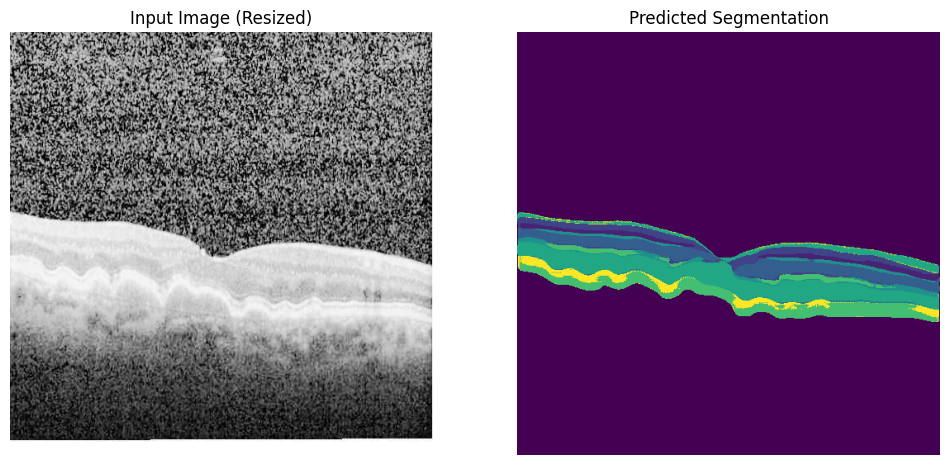

In [29]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")



uploaded_image_path = '/content/drive/MyDrive/oct_major_project/drusen 2.v1i.coco-segmentation/train/DRUSEN-8023853-102_jpeg.rf.0fcea15b0f8b2e94c8f915e3edea504d.jpg'


predict_on_single_image(model, uploaded_image_path, DEVICE)